In [2]:
# !pip uninstall example_project
!pip install retworkx
!pip install . --upgrade
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime.fake_provider import FakeKyiv
from qiskit_transpiler_service.transpiler_service import TranspilerService
from qkh2024.grader import scorer
from qiskit.transpiler.passes import Unroll3qOrMore
from qiskit.transpiler.passmanager import PassManager, StagedPassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
print(list_stage_plugins("layout"))
print(list_stage_plugins("routing"))

Processing c:\users\seungmin jeon\desktop\quantum-korea-hackathon-2024
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for example_project: filename=example_project-0.1.0-py3-none-any.whl size=5053 sha256=9c8410afbfc4c64b36bbf7e31932050a033d82c1e44d95ca72934df2a4aeabdf
  Stored in directory: c:\users\seungmin jeon\appdata\local\pip\cache\wheels\4b\80\7c\45108e126e3b5ec8fcf012992b502a01015315a379c50fcd30
Successfully built example_project
  Attempting uninstall: example_project
    Found existing installation: example_project 0.1.0
    Uninstalling example_project-0.1.0:
      Successfully uninstalled example_project-0.1.0
['vf10', 'default', 'dense', 'sabre', 'trivial']
['bsabre', 'metasabre',

Connect backend

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum", token="fa0372ac79105aaec3e2bbff758cb43dc9506244ea5fba95957381cd14f56a38fc96f0fbc31e98d93318017772027e45f80ab6e71678e18d44e05f8f6655516b")
# service.save_account(channel="ibm_quantum", token="fa0372ac79105aaec3e2bbff758cb43dc9506244ea5fba95957381cd14f56a38fc96f0fbc31e98d93318017772027e45f80ab6e71678e18d44e05f8f6655516b")
backend = service.backend("ibm_sherbrooke")
scorer = scorer()

Get existing pass manager

In [4]:
transpiler_list = []
transpiler_names = []

Define custom pass manager

In [5]:
seed = 10000
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)
transpiler_list.append(pm_lv0)
transpiler_names.append("preset pass manager level 0")

pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed)
transpiler_list.append(pm_lv1)
transpiler_names.append("preset pass manager level 1")

pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed)
transpiler_list.append(pm_lv2)
transpiler_names.append("preset pass manager level 2")

pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed)
transpiler_list.append(pm_lv3)
transpiler_names.append("preset pass manager level 3")

In [ ]:
from my_qiskit_plugin import VF2Layout as VF2
from my_qiskit_plugin2 import BaseSabreSwap
from qiskit.transpiler.preset_passmanagers import common

pm_our = generate_preset_pass_manager(
    optimization_level=2,
    backend=backend,
    layout_method="sabre",
    routing_method="bsabre",
    translation_method="synthesis",
)

# my_init = PassManager(Unroll3qOrMore())
# # my_routing = PassManager(
#     # OurSabreSwap(coupling_map=backend.coupling_map)
# # )
# my_layout = PassManager(VF2(coupling_map=backend.coupling_map))
# my_layout += common.generate_embed_passmanager(backend.coupling_map)
# my_routing = PassManager(BaseSabreSwap(coupling_map=backend.coupling_map))
# pm_our = StagedPassManager(
#     stages=["init", "layout", "routing", "translation"], 
#     # init=pm_lv2.init, 
#     init=my_init, 
#     # layout=pm_lv2.layout,
#     layout=my_layout,
#     # layout="vf2",
#     # routing=pm_lv2.routing,
#     routing=my_routing,
#     translation=pm_lv2.translation
# )
transpiler_list.append(pm_our)
transpiler_names.append("our transpiler")

Transpile and collect result stats

In [ ]:
tr_depths = [[] for i in range(len(transpiler_list))]
tr_gate_counts = [[] for i in range(len(transpiler_list))]
tr_cnot_counts = [[] for i in range(len(transpiler_list))]
tr_scores = [[] for i in range(len(transpiler_list))]
# print(tr_depths, len(transpiler_list))

num_qubits = np.arange(2, 7)

for nq in num_qubits:
    print(f'Start transpiling the {nq}-qubit circuit')
    circuit = QuantumCircuit(nq)
    circuit.h(range(nq))
    circuit.append(QFT(nq, do_swaps=False, inverse=True).decompose(), range(nq))
    for i in range(len(transpiler_list)):
        print(transpiler_names[i])
        isa_circuit = transpiler_list[i].run(circuit)
        scorer.validate(circuit, isa_circuit, backend)
        tr_depths[i].append(isa_circuit.depth())
        tr_gate_counts[i].append(sum(isa_circuit.count_ops().values()))
        tr_cnot_counts[i].append(isa_circuit.num_nonlocal_gates())
        tr_scores[i].append(scorer.score(isa_circuit, backend))


Start transpiling the 2-qubit circuit
preset pass manager level 0
Basis gate check passed!
The connections match with the backend
Congratualtions! Your circuit is within the given tolerance of the original circuit
preset pass manager level 1
Basis gate check passed!
The connections match with the backend
Congratualtions! Your circuit is within the given tolerance of the original circuit
preset pass manager level 2
Basis gate check passed!
The connections match with the backend
Congratualtions! Your circuit is within the given tolerance of the original circuit
preset pass manager level 3
Basis gate check passed!
The connections match with the backend
Congratualtions! Your circuit is within the given tolerance of the original circuit
our transpiler


TranspilerError: 'FullAncillaAllocation: The layout refers to a qubit that does not exist in circuit.'

Show results and scores

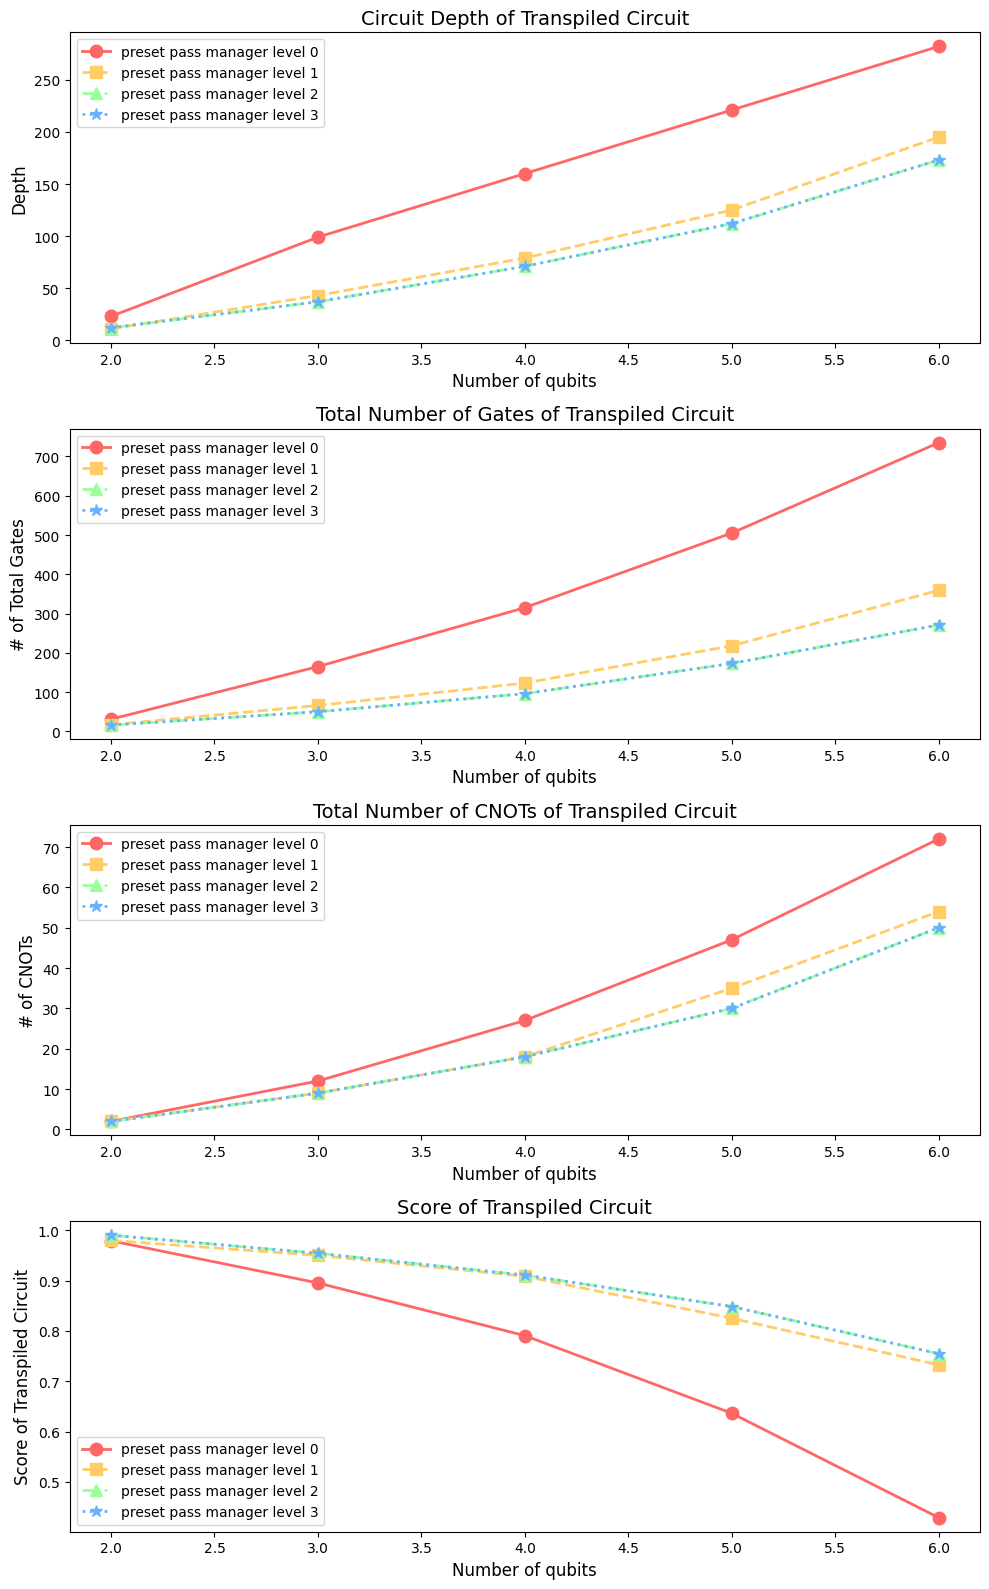

In [ ]:
import matplotlib.pyplot as plt

ax = num_qubits
# opt_list = ['Optimization Level 1', 'Optimization Level 2', 'Optimization Level 3', 'AI Optimization']
opt_list = transpiler_names
markers = ['o', 's', '^', '*', 'D', 'P', 'X']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
colors = ['#FF6666', '#FFCC66', '#99FF99', '#66B2FF', '#FF99FF', '#FF6666', '#FFCC66']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 16))

# Plot 1: Circuit Depth
for i in range(len(transpiler_list)):
    ax1.plot(ax, tr_depths[i], label=opt_list[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("Number of qubits", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(len(transpiler_list)):
    ax2.plot(ax, tr_gate_counts[i], label=opt_list[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("Number of qubits", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Total Number of CNOTs
for i in range(len(transpiler_list)):
    ax3.plot(ax, tr_cnot_counts[i], label=opt_list[i], marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("Number of qubits", fontsize=12)
ax3.set_ylabel("# of CNOTs", fontsize=12)
ax3.set_title("Total Number of CNOTs of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

# Plot 4: Score of Transpiled Circuit
for i in range(len(transpiler_list)):
    ax4.plot(ax, tr_scores[i], label=opt_list[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax4.set_xlabel("Number of qubits", fontsize=12)
ax4.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax4.set_title("Score of Transpiled Circuit", fontsize=14)
ax4.legend(fontsize=10)

fig.tight_layout()
plt.show()